<a href="https://colab.research.google.com/github/Koks-creator/FakeNewsDetectionApi/blob/main/FakeNewsDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import string
from typing import Tuple
from collections import Counter, defaultdict
import pickle
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras.models import Sequential
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
MAX_SEQUENCE_LENGTH = 6000
EMBEDDING_DIM = 256
TEST_SPLIT = 0.2
BATCH_SIZE = 32
EPOCHS = 5
CLASSES = ["Fake", "Real"]

TEXT_DATA = 'https://raw.githubusercontent.com/lutzhamel/fake-news/master/data/fake_or_real_news.csv'
TOKENIZER_PATH = "tokenizer.pkl"
MODEL_PATH = "FakeNewsModel.h5"

**Preprocess data**

In [ ]:
df = pd.read_csv(TEXT_DATA)
df.drop(labels=['id', 'title'], axis='columns', inplace=True)
mask = list(df['text'].apply(lambda x: len(x) > 0))
df = df[mask]

In [ ]:
df[['text', 'label']].iloc[2].text

'U.S. Secretary of State John F. Kerry said Monday that he will stop in Paris later this week, amid criticism that no top American officials attended Sunday’s unity march against terrorism.\n\nKerry said he expects to arrive in Paris Thursday evening, as he heads home after a week abroad. He said he will fly to France at the conclusion of a series of meetings scheduled for Thursday in Sofia, Bulgaria. He plans to meet the next day with Foreign Minister Laurent Fabius and President Francois Hollande, then return to Washington.\n\nThe visit by Kerry, who has family and childhood ties to the country and speaks fluent French, could address some of the criticism that the United States snubbed France in its darkest hour in many years.\n\nThe French press on Monday was filled with questions about why neither President Obama nor Kerry attended Sunday’s march, as about 40 leaders of other nations did. Obama was said to have stayed away because his own security needs can be taxing on a country, 

In [ ]:
df["IntLabel"] = df["label"].apply(lambda x: 0 if x == "FAKE" else 1)
# df["IntLabel"] = df["label"].apply(lambda x: 0 if x == "REAL" else 1)

In [ ]:
df[['text', 'label', 'IntLabel']]

,text,label,IntLabel
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,0
2,U.S. Secretary of State John F. Kerry said Mon...,REAL,1
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,0
4,It's primary day in New York and front-runners...,REAL,1
...,...,...,...
6330,The State Department told the Republican Natio...,REAL,1
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE,0
6332,Anti-Trump Protesters Are Tools of the Oligar...,FAKE,0
6333,"ADDIS ABABA, Ethiopia —President Obama convene...",REAL,1


In [ ]:
texts = df["text"]
labels = df["IntLabel"]

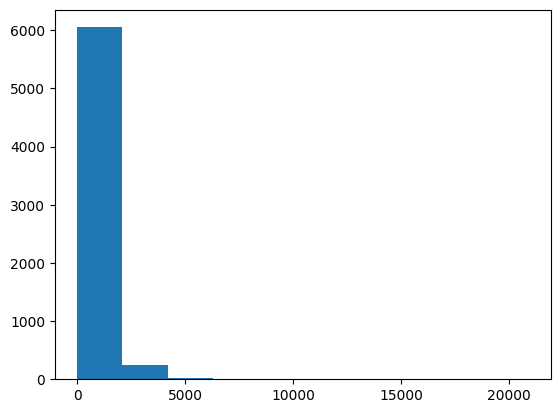

In [ ]:
text_lengths = texts.apply(lambda x: len(x.split(" ")))
plt.hist(text_lengths)
plt.show()

In [ ]:
print(df["text"][df["IntLabel"] == 1].count())
print(df["text"][df["IntLabel"] == 0].count())

3171
3164


In [ ]:
df["text"]

0       Daniel Greenfield, a Shillman Journalism Fello...
1       Google Pinterest Digg Linkedin Reddit Stumbleu...
2       U.S. Secretary of State John F. Kerry said Mon...
3       — Kaydee King (@KaydeeKing) November 9, 2016 T...
4       It's primary day in New York and front-runners...
                              ...                        
6330    The State Department told the Republican Natio...
6331    The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...
6332     Anti-Trump Protesters Are Tools of the Oligar...
6333    ADDIS ABABA, Ethiopia —President Obama convene...
6334    Jeb Bush Is Suddenly Attacking Trump. Here's W...
Name: text, Length: 6335, dtype: object

In [ ]:
class DataCleaning:

    @staticmethod
    def remove_html_tags(raw_text: str) -> str:
        cleanr = re.compile("<.*?>")
        cleantext = re.sub(cleanr, '', raw_text)
        return cleantext

    @staticmethod
    def remove_url(text: str) -> str:
        url_pattern = re.compile(r"http[s]?://\S+.\S+.\S+")
        return url_pattern.sub(r"", text)

    @staticmethod
    def remove_punct(text: str) -> str:
        translator = str.maketrans("", "", string.punctuation)
        return text.translate(translator)

    @staticmethod
    def remove_non_ascii(text: str) -> str:
        pattern = re.compile(r"[^\x00-\x7f][ ]?")
        return pattern.sub(r"", text)

In [ ]:
dc = DataCleaning()

texts = texts.apply(lambda x: dc.remove_html_tags(x))
texts = texts.apply(lambda x: dc.remove_url(x))
texts = texts.apply(lambda x: dc.remove_punct(x))
texts = texts.apply(lambda x: dc.remove_non_ascii(x))

In [ ]:
texts

0       Daniel Greenfield a Shillman Journalism Fellow...
1       Google Pinterest Digg Linkedin Reddit Stumbleu...
2       US Secretary of State John F Kerry said Monday...
3       Kaydee King KaydeeKing November 9 2016 The les...
4       Its primary day in New York and frontrunners H...
                              ...                        
6330    The State Department told the Republican Natio...
6331    The Pin PBS Should Stand for Plutocraticor Pen...
6332     AntiTrump Protesters Are Tools of the Oligarc...
6333    ADDIS ABABA Ethiopia President Obama convened ...
6334    Jeb Bush Is Suddenly Attacking Trump Heres Why...
Name: text, Length: 6335, dtype: object

In [ ]:
# Count words

def count_words(col: pd.Series) -> Counter:
    count = Counter()

    for text in col.values:
        for word in text.split():
            count[word] += 1

    return count

In [ ]:
word_counter = count_words(texts)
unique_num_words = len(word_counter)

In [ ]:
unique_num_words

135017

In [ ]:
# Setup tokenizer

tokenizer = Tokenizer(num_words=unique_num_words)
tokenizer.fit_on_texts(texts)

In [ ]:
sequences = tokenizer.texts_to_sequences(texts)

In [ ]:
word_index = tokenizer.word_index  # mapping

In [ ]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', truncating='pre')

In [ ]:
data.shape

(6335, 6000)

In [ ]:
data[0]

array([  0,   0,   0, ..., 391, 765,  23], dtype=int32)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=TEST_SPLIT)

In [ ]:
print(len(x_train))
print(len(x_val))

5068
1267


**Build and train model**

Embeddings with convolutional neural networks (CNNs) can be beneficial in various natural language processing (NLP) tasks. Embeddings are dense vector representations of words or tokens that capture semantic relationships between them. When combined with convolutional layers, these embeddings can enhance the performance of models in tasks such as text classification, sentiment analysis, and sequence labeling. Here are some reasons why embeddings and convolutional layers are often used together:
<br>
<br>

**Semantic Representation**:

Embeddings provide a more meaningful and semantically rich representation of words compared to one-hot encoding. This allows the convolutional layers to capture more intricate relationships between words in the input data.
<br>
<br>
**Dimensionality Reduction:**

Word embeddings usually have lower dimensionality compared to one-hot encodings, which helps in reducing the computational complexity of the model. Convolutional layers applied to lower-dimensional embeddings are computationally more efficient.
<br>
<br>
**Local Context:**

Convolutional layers are designed to capture local patterns or features in the input data. When applied to word embeddings, they can identify relevant local patterns within a sequence of words, aiding in understanding the local context of a word within a sentence.
Parameter Sharing:

Convolutional layers use parameter sharing, meaning the same filter is applied to different parts of the input. This enables the network to learn spatial hierarchies of features. When combined with embeddings, parameter sharing allows the model to recognize similar semantic structures in different parts of the input.
<br>
<br>
**Invariance to Word Order:**

CNNs with embeddings can exhibit some degree of invariance to the order of words in a sequence. This can be advantageous for tasks where the exact word order is less important, such as text classification or sentiment analysis.
<br>
<br>
**Pooling Operations:**

Pooling layers, often used in conjunction with convolutional layers, help in reducing the spatial dimensions of the input data. When applied to embeddings, pooling can aggregate information at different scales, helping the model focus on important features.
<br>
<br>
**Efficient Feature Extraction:**

Convolutional layers act as feature extractors, and when combined with embeddings, they efficiently capture hierarchical features in the input data. This can be especially useful for understanding the hierarchical structure of language.
<br>
<br>
<br>
<br>
In summary, using embeddings with convolutional layers allows neural networks to leverage semantically rich representations and capture local patterns, making them effective for various NLP tasks.

In [ ]:
model = Sequential()
model.add(layers.Embedding(unique_num_words, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, trainable=True))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 6000, 256)         34564352  
                                                                 
 conv1d_3 (Conv1D)           (None, 5996, 128)         163968    
                                                                 
 global_max_pooling1d_3 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 34744961 (132.54 MB)
Trainable params: 34744961 (132.54 MB)
Non-trainable params: 0 (0.00 Byte)
__________

In [ ]:
history = model.fit(x_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val, y_val))

Epoch 1/5
159/159 [==============================] - 21s 118ms/step - loss: 0.4238 - accuracy: 0.7950 - val_loss: 0.2227 - val_accuracy: 0.9274
Epoch 2/5
159/159 [==============================] - 17s 108ms/step - loss: 0.1392 - accuracy: 0.9457 - val_loss: 0.2688 - val_accuracy: 0.8887
Epoch 3/5
159/159 [==============================] - 16s 101ms/step - loss: 0.0385 - accuracy: 0.9888 - val_loss: 0.1365 - val_accuracy: 0.9519
Epoch 4/5
159/159 [==============================] - 17s 105ms/step - loss: 0.0041 - accuracy: 0.9998 - val_loss: 0.1637 - val_accuracy: 0.9558
Epoch 5/5
159/159 [==============================] - 17s 106ms/step - loss: 3.6241e-04 - accuracy: 1.0000 - val_loss: 0.1705 - val_accuracy: 0.9534


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

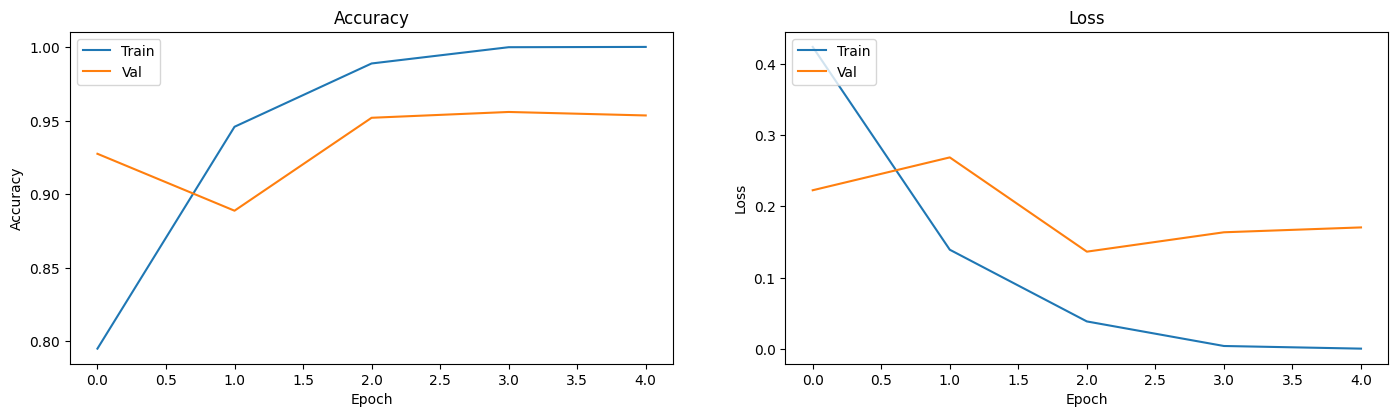

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.tight_layout(pad=5.0)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title("Accuracy")
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Val'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title("Loss")
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Val'], loc='upper left')

plt.show()

**Predictions**

In [ ]:
model.evaluate(x_val, y_val, batch_size=200)

7/7 [==============================] - 4s 247ms/step - loss: 0.1705 - accuracy: 0.9534


[0.1704949289560318, 0.9534333348274231]

In [ ]:
def get_accuracy_details(x: np.array, y: np.array, model: Sequential, classes: list) -> Tuple[float, defaultdict]:
    acc_per_class = defaultdict(int)
    class_counters = defaultdict(int)

    data_len = len(y)
    matching_values = (x == y).sum()
    overall_acc = round(matching_values/data_len * 100, 4)

    for prediction, label in zip(x, y):
      class_counters[classes[label]] += 1
      if label == prediction:
          acc_per_class[classes[label]] += 1

    for class_name in acc_per_class.keys():
        acc_per_class[class_name] = round(acc_per_class[class_name] / class_counters[class_name] * 100, 4)


    return round(matching_values/data_len * 100, 4), acc_per_class

In [ ]:
preds = model.predict(x_val)

x = preds.round().flatten()
y = np.array(y_val)

get_accuracy_details(x=preds.round().flatten(), y=np.array(y_val), model=model, classes=CLASSES)

40/40 [==============================] - 1s 18ms/step


(95.3433, defaultdict(int, {'Real': 95.4839, 'Fake': 95.2087}))

In [ ]:
text1 = """
Google Pinterest Digg Linkedin Reddit Stumbleupon Print Delicious Pocket Tumblr
There are two fundamental truths in this world: Paul Ryan desperately wants to be president. And Paul Ryan will never be president. Today proved it.
In a particularly staggering example of political cowardice, Paul Ryan re-re-re-reversed course and announced that he was back on the Trump Train after all. This was an aboutface from where he was a few weeks ago. He had previously declared he would not be supporting or defending Trump after a tape was made public in which Trump bragged about assaulting women. Suddenly, Ryan was appearing at a pro-Trump rally and boldly declaring that he already sent in his vote to make him President of the United States. It was a surreal moment. The figurehead of the Republican Party dosed himself in gasoline, got up on a stage on a chilly afternoon in Wisconsin, and lit a match. . @SpeakerRyan says he voted for @realDonaldTrump : “Republicans, it is time to come home” https://t.co/VyTT49YvoE pic.twitter.com/wCvSCg4a5I
— ABC News Politics (@ABCPolitics) November 5, 2016
The Democratic Party couldn’t have asked for a better moment of film. Ryan’s chances of ever becoming president went down to zero in an instant. In the wreckage Trump is to leave behind in his wake, those who cravenly backed his campaign will not recover. If Ryan’s career manages to limp all the way to 2020, then the DNC will have this tape locked and loaded to be used in every ad until Election Day.
The ringing endorsement of the man he clearly hates on a personal level speaks volumes about his own spinelessness. Ryan has postured himself as a “principled” conservative, and one uncomfortable with Trump’s unapologetic bigotry and sexism. However, when push came to shove, Paul Ryan – like many of his colleagues – turned into a sniveling appeaser. After all his lofty tak about conviction, his principles were a house of cards and collapsed with the slightest breeze.
What’s especially bizarre is how close Ryan came to making it through unscathed. For months the Speaker of the House refused to comment on Trump at all. His strategy seemed to be to keep his head down, pretend Trump didn’t exist, and hope that nobody remembered what happened in 2016. Now, just days away from the election, he screwed it all up.
If 2016’s very ugly election has done any good it’s by exposing the utter cowardice of the Republicans who once feigned moral courage. A reality television star spit on them, hijacked their party, insulted their wives, and got every last one of them to kneel before him. What a turn of events.
Featured image via Twitter
"""


text2 = """
The Empira Group has examined the developments and challenges of office property markets in Europe, in particular by linking them to economic, demographic and regulatory indicators, as part of a recent research report. The study analysed the office markets of 24 major European cities.
In the previous dynamic market phase, there was a strong increase in new office space in the seven largest office locations in Germany, particularly in Berlin. Until 2014, less than 200,000 sqm of new office space were created in the capital each year, whereas in 2021 and 2022, the figure was over 500,000 sqm in each year.
There is a high need for refurbishment, as three quarters of all buildings in the EU are currently considered energy inefficient. This also has a direct impact on the office property market. Energy efficiency is becoming a key criterion in the selection of office space and therefore has a significant influence on the qualitative requirements of buyers.
Prof Steffen Metzner, head of research at the Empira Group
Only a small proportion of office properties in Germany's top seven cities are currently certified – between 7 pct in Stuttgart and 26 pct in Frankfurt am Main. Certification practice to date indicates that energy efficient buildings in particular have been certified in order to increase their value. Certification was often avoided for less efficient buildings, which indicates high costs compared to the benefits. It is therefore to be expected that many of the buildings still to be certified will require extensive energy refurbishment.
In European countries, the proportion of buildings that do not fulfil the requirements of efficiency class D or higher varies considerably. The European Commission only publishes specific data on this for selected countries. In the Netherlands, almost half of all office space corresponds to at least energy efficiency class B, which indicates a high proportion of office buildings with an excellent energy standard. Many of these buildings are either modern new buildings that meet current energy standards or older buildings that have been modernised through extensive renovations. France and the United Kingdom have similar energy profiles for their office buildings. In both countries, around 70 pct of office buildings are assigned to energy efficiency classes C to E. However, more than 20 pct of office buildings in these countries meet a very high energy standard. The short-term need for action in these countries is comparatively low.
As the new construction rates of the other German cities fall significantly behind Berlin, it can be concluded that a continuous renewal of the existing stock is not realistic in the medium term purely on the basis of current levels of new office construction activity. With new construction rates of just over one per cent, the office stock in Germany's top 7 locations continues to age. It can be assumed that there is a comparatively high need for investment to modernise the German stock.
"""

text3 = """
U.S. Secretary of State John F. Kerry said Monday that he will stop in Paris later this week, amid criticism that no top American officials attended Sunday’s unity march against terrorism.
Kerry said he expects to arrive in Paris Thursday evening, as he heads home after a week abroad. He said he will fly to France at the conclusion of a series of meetings scheduled for Thursday in Sofia, Bulgaria. He plans to meet the next day with Foreign Minister Laurent Fabius and President Francois Hollande, then return to Washington.
The visit by Kerry, who has family and childhood ties to the country and speaks fluent French, could address some of the criticism that the United States snubbed France in its darkest hour in many years.
The French press on Monday was filled with questions about why neither President Obama nor Kerry attended Sunday’s march, as about 40 leaders of other nations did. Obama was said to have stayed away because his own security needs can be taxing on a country, and Kerry had prior commitments.
Among roughly 40 leaders who did attend was Israeli Prime Minister Benjamin Netanyahu, no stranger to intense security, who marched beside Hollande through the city streets. The highest ranking U.S. officials attending the march were Jane Hartley, the ambassador to France, and Victoria Nuland, the assistant secretary of state for European affairs. Attorney General Eric H. Holder Jr. was in Paris for meetings with law enforcement officials but did not participate in the march.
Kerry spent Sunday at a business summit hosted by India’s prime minister, Narendra Modi. The United States is eager for India to relax stringent laws that function as barriers to foreign investment and hopes Modi’s government will act to open the huge Indian market for more American businesses.
In a news conference, Kerry brushed aside criticism that the United States had not sent a more senior official to Paris as “quibbling a little bit.” He noted that many staffers of the American Embassy in Paris attended the march, including the ambassador. He said he had wanted to be present at the march himself but could not because of his prior commitments in India.
“But that is why I am going there on the way home, to make it crystal clear how passionately we feel about the events that have taken place there,” he said.
“And I don’t think the people of France have any doubts about America’s understanding of what happened, of our personal sense of loss and our deep commitment to the people of France in this moment of trauma.”
"""


text4 = """
Brutal’ Arctic blast expected to bring frigid temperatures to North America
Extreme cold warning issued in Canada as US forecasters warn of wind chills in Texas and major snow in midwest and east coast

Oliver Milman in New York and Leyland Cecco in Toronto
Thu 11 Jan 2024 17.44 CET
A “bitter” blast of cold Arctic air is set to bring dangerously frigid temperatures to swaths of North America, forecasters have warned.

In Canada, frigid Arctic air is being pushed from the Northwest Territories down into the province of Alberta, where Environment Canada has issued an extreme cold warning. Alberta’s largest city, Calgary, could see temperatures plummet to -34.6F (-37C) on Friday, reaching a daytime high of -23.8F (-31C). This would mark the coldest January day in two decades for the city. Over the weekend, strong winds could make temperatures feel closer to -58F (-50C). In these conditions, experts say exposed skin can succumb to frostbite in less than a minute.

The cold front is set to also set to push from the Rockies towards northern US plains on Thursday night before advancing south, the National Weather Service said, likely causing daily cold records to tumble in several places. In Texas and the south east, “dangerously cold wind chills” are expected that will push temperatures below freezing.


“Temperatures will be brutal compared to the relatively mild conditions that have been experienced for much of the winter season up to this point in time,” an alert from the weather service said.

Most of the United States is expected to be hit by the cold weather, with Chicago expected to go below -10F (-23C) for the first time since 2019, and Oklahoma City below 0F (-17.7) for the first time since February 2021. Wind chills could make push temperatures in parts of the Rockies to -30F (-34.4C), posing the risk of hypothermia to anyone caught in this weather.

Meanwhile, major snowstorms, sleet and rain are expected to affect the midwest and east coast, with the weather service warning of “major disruption” from 12in of snow set to fall upon parts of Michigan, with high winds set to cause blizzard conditions in the Great Lakes region. In the north-east, there could be river and coastal flooding due to storms and heavy rain.

The cold front will be a significant change for parts of the country that have so far experienced a very mild winter, with meagre snowfall and above-average temperatures.

Last year was the fifth hottest year on record in the US, the National Oceanic and Atmospheric Administration confirmed on Tuesday, with 2023 being the hottest globally by a large margin.

Climate researchers have theorized that sudden extreme blasts of cold weather in the US could, in some cases, be fueled by global heating. The Arctic is warming up four times faster than the rest of the planet, causing changes to the circular pattern of winds called the polar vortex, which usually keeps the cold massed upon the polar region.

As this pattern becomes more “wavy”, freezing cold can drop southwards, which is what researchers believed happened during the deadly cold snap in Texas in 2021.
"""


text5 = """
Bangladesh: Statement by the High Representative on behalf of the European Union on the parliamentary elections
The European Union takes note of the outcome of the Parliamentary elections, which were held in Bangladesh last Sunday and reiterates that the long-term EU-Bangladesh partnership is underpinned by the values of democracy, human rights and the rule of law.

The EU regrets that not all major parties participated in this election.

The EU welcomes the agreement of the authorities to make public the upcoming report and recommendations of the EU Election Expert Mission. In the same spirit of transparency and accountability, we call upon the relevant authorities to ensure a timely and full investigation of all reported election irregularities.

The EU condemns the acts of violence that occurred during the electoral period and urges everybody to refrain from violence in the post-election period. It is also key that the rule of law, judicial independence, due process and the right to peaceful assembly are respected and upheld in this period and beyond. In this regard, detention of opposition figures is highly concerning.

The EU strongly encourages all stakeholders to respect political pluralism, democratic values and international human rights standards and to engage in peaceful dialogue. It is essential that the media, civil society and political parties can carry out their work without censorship or fear of reprisals.

The EU will continue to work with the Government of Bangladesh on the priorities that characterise our longstanding relations in the political, human rights, trade and development spheres including the country’s possible future access to the GSP+ preferential trade scheme.
"""


text6 = """
Keir Starmer denies he knew CPS was prosecuting post office operators
Labour leader was director of public prosecutions when three cases brought by CPS resulted in convictions

Ben Quinn Political Correspondent
@BenQuinn75
Wed 10 Jan 2024 23.30 CET
Keir Starmer has denied he was aware of Crown Prosecution Service prosecutions against post office operators caught up in the Horizon IT scandal when he headed the agency.

The Labour leader’s comments came as calls grew for the former Post Office boss Paula Vennells to hand back £3m in bonuses earned during her period in charge.

Starmer, who was director of public prosecutions between 2008 and 2013, addressed questions about what he knew about up to 38 prosecutions of post office operators initiated by the CPS.

“No, I wasn’t aware of any of them. I think there was a small number within a 20-year window, that’s all I know,” he said.


“I don’t even now – I think the CPS are helping with inquiries – how many of those may or may not have involved Horizon.”

While the Post Office itself prosecuted hundreds of post office operators based on the faulty Horizon IT system, it has emerged from official reviews that 10 cases taken by the CPS resulted in convictions. Three occurred while Starmer was DPP.

“They didn’t go to his desk,” a Labour spokesperson said.

Separately, pressure continue to mount on Vennells, 64, a day after she announced she would hand back the CBE awarded to her when she headed the Post Office, with Rishi Sunak’s spokesperson signalling he took a dim view of those holding on to bonuses.

“In general terms it would be wrong for businesses or individuals to profit from this miscarriage of justice,” he said.

Kevin Hollinrake, minister for postal services, also conceded in parliament that many would see Vennells serving as a Cabinet Office director during 2019 to 2020 as a “mistake”.

His comments followed a question from Liberal Democrat Daisy Cooper, who said: “Paula Vennells has quite rightly handed back her CBE, but many subpostmasters are asking why she was given it in the first place, and also why she was given a role as director of the Cabinet Office?”

Hollinrake responded: “It clearly was prior to my time in government, but she raises some interesting points, I don’t know the answer to her question. I think with hindsight many people would see that as a mistake, but very happy to take that away.”

skip past newsletter promotion
Sign up to First Edition

Free daily newsletter
Our morning email breaks down the key stories of the day, telling you what’s happening and why it matters


Privacy Notice: Newsletters may contain info about charities, online ads, and content funded by outside parties. For more information see our Privacy Policy. We use Google reCaptcha to protect our website and the Google Privacy Policy and Terms of Service apply.
after newsletter promotion

After Hollinrake’s comments, the Lib Dems also called on the deputy prime minister, Oliver Dowden, to “come clean” over his failure to sack Vennells. Dowden was Cabinet Office minister in 2019 when a high court judgment was handed down in which a group of 555 post office operators won a group action brought against the Post Office.

The high court ruled that Horizon contained a number of “bugs, errors and defects”, and there was a “material risk” that shortfalls in post office branch accounts were caused by the system.

A Conservative former minister also claimed that while he was in government, Vennells refused to meet him without her lawyer present.

George Freeman, a former business minister, told MPs: “I was never minister for the Post Office, but I remember as a minister in the department being asked to cover for an absent minister, and when refusing to just read out the speech but ask for a proper day of briefings from officials, and asked to meet Paula Vennells, I was told she would refuse to meet me without her lawyer.”
"""

In [ ]:

text_array = np.array([text1, text2, text3, text4, text5, text6])
tokinized_array = tokenizer.texts_to_sequences(text_array)
data = pad_sequences(tokinized_array,
                     maxlen=MAX_SEQUENCE_LENGTH,
                     padding='pre',
                     truncating='pre')


preds = model.predict(data).round()
for pred in preds.squeeze():
    print(CLASSES[int(pred)])



1/1 [==============================] - 0s 252ms/step
Fake
Real
Real
Real
Fake
Real


**Save model and tokenizer**

In [ ]:
with open(TOKENIZER_PATH, "wb") as f:
    pickle.dump(tokenizer, f)


model.save(MODEL_PATH)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Load model and tokenizer**

In [ ]:
with open(TOKENIZER_PATH, "rb") as f:
    tokenizer = pickle.load(f)


model = tf.keras.models.load_model(MODEL_PATH)